# HSCT survival: Weibull accelerated failure model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

notebook_num='02.2'
feature_pval_cutoff=0.001
dataset='Continuous target encoded'

# Feature type definitions file
feature_types_dict_file=f'{config.PROCESSED_DATA}/01.1-feature_type_dict.pkl'

# Dataset definition file
datasets_file=f'{config.PROCESSED_DATA}/01.2-dataset_definitions.pkl'

# Significant features file
significant_features_file=f'{config.PROCESSED_DATA}/{notebook_num}-weibullAFT_significant_features.pkl'

# Model file
waft_model_file=f'{config.MODELS_PATH}/{notebook_num}-weibullAFT_model.pkl'

# Output file
survival_file=f'{config.PROCESSED_DATA}/{notebook_num}-weibullAFT_survival.pkl'


## 1. Load data

In [2]:
# Load dataset definitions
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print('Datasets:\n')
for description, filepath in datasets.items():
    print(f' {description}')

# Load feature definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types=pickle.load(input_file)

print('\nFeature types:\n')
for feature_type, features in feature_types.items():
    print(f' {feature_type}: {features}\n')

# Load one of the datasets
with open(datasets[dataset], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Combine features and labels
training_df=data_dict['Training features']
training_df[['efs', 'efs_time']]=data_dict['Training labels']

testing_df=data_dict['Testing features']
testing_df[['efs', 'efs_time']]=data_dict['Testing labels']

Datasets:

 Nominal one-hot/ordinal encoded, NANs encoded
 Nominal one-hot/ordinal encoded, NANs imputed
 All ordinal encoded, NAN encoded
 All ordinal encoded, NAN imputed
 Binary target encoded
 Binary target encoded, power transformed
 Continuous target encoded
 Continuous target encoded, power transformed

Feature types:

 Interval: ['donor_age', 'age_at_hct']

 Ordinal: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

 Nominal: ['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'pr

In [3]:
training_df.describe()

,psych_disturb,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,tce_imm_match,...,hla_match_drb1_high,hla_low_res_10,dri_score,cyto_score,cmv_status,cyto_score_detail,donor_age,age_at_hct,efs,efs_time
count,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,...,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000,20160.000000
mean,23.297261,23.297245,23.297340,23.297290,23.296812,23.296876,23.297130,23.297347,23.293371,23.296519,...,23.296805,23.297012,23.296837,23.297271,23.296834,23.297240,42.464154,38.668787,0.539087,23.297005
std,1.952019,2.143977,1.190867,1.732667,3.615540,0.257068,1.438774,2.060698,4.548669,1.653017,...,0.818039,1.081143,3.128467,3.366109,1.209158,3.415252,14.898591,21.122827,0.498482,24.924465
min,18.332289,19.247242,19.092973,18.188693,21.000471,23.041356,18.172956,17.193005,15.128128,16.782230,...,22.497112,20.569370,18.593479,19.625438,22.417264,15.092360,18.010000,0.044000,0.000000,0.333000
25%,24.255348,24.469782,22.744724,23.949337,21.000471,23.279073,23.699641,24.122430,21.271546,21.654616,...,22.497112,23.133031,22.320664,19.625438,22.417264,22.615589,28.893500,19.722500,0.000000,5.625500
50%,24.255348,24.469782,23.980891,23.949337,21.000471,23.279073,23.699641,24.122430,21.800668,24.397329,...,23.228387,23.551392,22.320664,22.990187,23.420092,22.615589,40.289000,40.931500,1.000000,9.826000
75%,24.255348,24.469782,23.980891,23.949337,28.989121,23.279073,23.699641,24.122430,21.800668,24.498240,...,23.228387,23.551392,27.066364,27.765300,23.420092,26.110857,55.212250,55.970750,1.000000,35.183500
max,24.255348,24.469782,25.646015,23.949337,28.989121,25.907569,23.894947,24.122430,36.378200,28.158770,...,25.422148,24.608673,27.066364,27.765300,26.302364,26.110857,84.800000,73.670000,1.000000,156.819000


## 2. Weibull AFT model

### 2.1. Naive model

In [4]:
waft_model=WeibullAFTFitter()
waft_model.fit(training_df, duration_col='efs_time', event_col='efs')

<lifelines.WeibullAFTFitter: fitted with 20160 total observations, 9292 right-censored observations>

In [5]:
waft_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 20160 total observations, 9292 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
   number of observations = 20160
number of events observed = 10868
           log-likelihood = -47874.99
         time fit was run = 2025-03-05 15:18:00 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                
lambda_ age_at_hct              -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        arrhythmia              -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
        cardiac                  0.05      1.05      0.01            0.03            0.06                1.03                1.06
        cmv_status               0.01      1.01      0.01           -0.01            0.03                0.99                1.03
        comorbidity_score        0.05      1.05      0.00            0.04            0.05                1.04                1.06
        conditioning_intensity   0.07      1.07      0.00            0.06            0.08                1.06                1.08
        cyto_score              -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
        cyto_score_detail        0.04      1.04      0.00            0.03            0.05                1.03                1.05
        diabetes                 0.02      1.02      0.01            0.00            0.03                1.00                1.03
        donor_age                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        donor_related           -0.02      0.98      0.05           -0.11            0.07                0.90                1.07
        dri_score                0.04      1.04      0.01            0.03            0.05                1.03                1.05
        ethnicity                0.01      1.01      0.02           -0.02            0.04                0.99                1.05
        graft_type               0.03      1.03      0.01            0.01            0.04                1.01                1.04
        gvhd_proph               0.02      1.02      0.01            0.01            0.04                1.01                1.04
        hepatic_mild            -0.00      1.00      0.01           -0.03            0.02                0.97                1.02
        hepatic_severe           0.02      1.02      0.01           -0.00            0.04                1.00                1.05
        hla_high_res_10         -0.02      0.98      0.02           -0.07            0.03                0.93                1.03
        hla_high_res_6          -0.05      0.96      0.03           -0.11            0.02                0.90                1.02
        hla_high_res_8           0.00      1.00      0.03           -0.06            0.06                0.94                1.06
        hla_low_res_10           0.01      1.01      0.03           -0.05            0.08                0.95                1.08
        hla_low_res_6           -0.05      0.95      0.04           -0.13            0.04                0.88                1.04
        hla_low_res_8            0.00      1.00      0.04           -0.08            0.08                0.92                1.08
        hla_match_a_high         0.03      1.03      0.02           -0.01            0.08                0.99                1.08
        hla_match_a_low          0.06      1.06      0.02            0.02            0.10                1.02                1.10
        hla_match_b_high         0.01      1.01      0.02           -0.03            0.05                0.97                1.05
        hla_match_b_low

### 2.2. Feature p-values

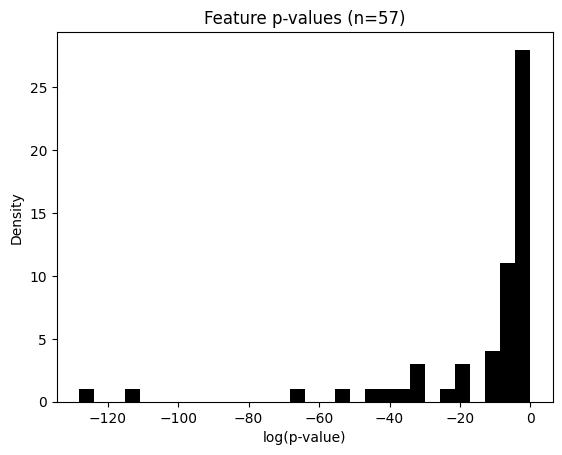

Significant features at alpha = 0.05: 31
Significant features at alpha = 0.001: 18


In [6]:
feature_pvals=waft_model.summary['p']
feature_pvals=feature_pvals.droplevel(0)
feature_pvals.drop('Intercept', axis=0, inplace=True)

plt.title(f'Feature p-values (n={len(feature_pvals)})')
plt.hist(np.log(feature_pvals), color='black', bins=30)
plt.xlabel('log(p-value)')
plt.ylabel('Density')
plt.show()

significant_features=feature_pvals[feature_pvals < 0.05]
print(f'Significant features at alpha = 0.05: {len(significant_features)}')

significant_features=feature_pvals[feature_pvals < 0.001]
print(f'Significant features at alpha = 0.001: {len(significant_features)}')

### 2.3. Feature selection

In [7]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()

# Save the significant features list
significant_features=list(training_significant_features_df.columns)

with open(significant_features_file, 'wb') as output_file:
    pickle.dump(significant_features, output_file)

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

### 2.4. Re-train model

In [8]:
waft_model=WeibullAFTFitter()
waft_model.fit(training_significant_features_df, duration_col='efs_time', event_col='efs')
waft_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 20160 total observations, 9292 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
   number of observations = 20160
number of events observed = 10868
           log-likelihood = -47974.95
         time fit was run = 2025-03-05 15:18:07 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                
lambda_ cardiac                  0.04      1.04      0.01            0.02            0.05                1.02                1.05
        comorbidity_score        0.05      1.06      0.00            0.05            0.06                1.05                1.06
        conditioning_intensity   0.07      1.07      0.00            0.06            0.08                1.07                1.08
        cyto_score_detail        0.04      1.04      0.00            0.03            0.05                1.03                1.05
        dri_score                0.05      1.05      0.00            0.04            0.06                1.04                1.06
        gvhd_proph               0.03      1.03      0.01            0.02            0.04                1.02                1.04
        hla_match_dqb1_high     -0.40      0.67      0.04           -0.48           -0.32                0.62                0.73
        hla_match_drb1_high      0.10      1.10      0.02            0.06            0.13                1.06                1.14
        in_vivo_tcd              0.04      1.04      0.00            0.03            0.04                1.03                1.04
        karnofsky_score          0.05      1.05      0.00            0.04            0.06                1.04                1.06
        prim_disease_hct         0.05      1.05      0.01            0.04            0.06                1.04                1.06
        pulm_severe              0.03      1.03      0.01            0.02            0.04                1.02                1.04
        race_group               0.07      1.07      0.01            0.05            0.09                1.05                1.09
        sex_match                0.11      1.12      0.01            0.09            0.12                1.10                1.13
        tbi_status               0.09      1.10      0.01            0.07            0.11                1.07                1.12
        tce_match                0.06      1.06      0.01            0.04            0.09                1.04                1.09
        vent_hist                0.25      1.28      0.06            0.13            0.37                1.14                1.45
        year_hct                 0.01      1.01      0.00            0.01            0.01                1.01                1.01
        Intercept              -13.02      0.00      1.72          -16.40           -9.64                0.00                0.00
rho_    Intercept               -0.36      0.69      0.01           -0.38           -0.35                0.68                0.71

                                cmp to      z      p  -log2(p)
param   covariate                                             
lambda_ cardiac                   0.00   6.07 <0.005     29.51
        comorbidity_score         0.00  14.30 <0.005    151.66
        conditioning_intensity    0.00  17.90 <0.005    235.62
        cyto_score_detail         0.00   9.31 <0.005     66.05
        dri_score                 0.00  10.06 <0.005     76.62
        gvhd_proph                0.00   5.42 <0.005     24.03
        hla_match_dqb1_high       0.00  -9.48 <0.005     68.42
        hla_match_drb1_high       0.00   4.83 <0.005     19.49
        in_vivo_tcd               0.00   8.55 <0.005     56.19
        karnofsky_score           0.00  10.78 <0.005     87.58
        prim_disease_hct          0.00   9.18 

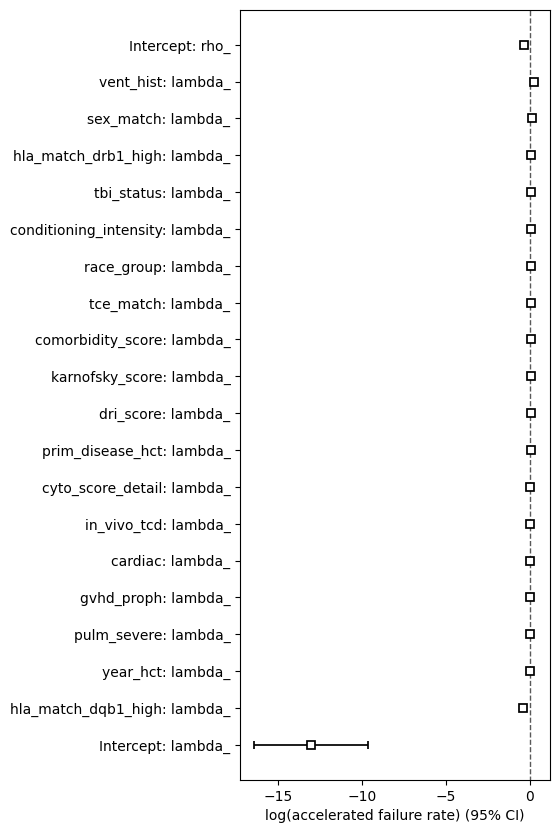

In [9]:
fig=plt.figure(figsize=[4,10])
waft_model.plot(figure=fig)
plt.show()

## 3. Survival forecasting

In [10]:
# Predict new survival function for training subjects
training_survival_functions=waft_model.predict_survival_function(training_significant_features_df)
training_expectations=waft_model.predict_expectation(training_significant_features_df)
training_survival_df=training_df[['efs', 'efs_time']].copy()
training_survival_df['Survival']=training_survival_functions.iloc[-1]
training_survival_df['Expectation']=training_expectations

# Predict new survival function for testing subjects
testing_survival_functions=waft_model.predict_survival_function(testing_significant_features_df)
testing_expectations=waft_model.predict_expectation(testing_significant_features_df)
testing_survival_df=testing_df[['efs', 'efs_time']].copy()
testing_survival_df['Survival']=testing_survival_functions.iloc[-1]
testing_survival_df['Expectation']=testing_expectations

training_survival_df.head()

,efs,efs_time,Survival,Expectation
0,1.0,2.142,0.129867,71.591859
1,0.0,105.944,0.172236,88.699859
2,0.0,34.787,0.252097,126.037167
3,1.0,6.964,0.034022,34.632768
4,1.0,5.541,0.041079,37.613844


### 3.1. Survival curves

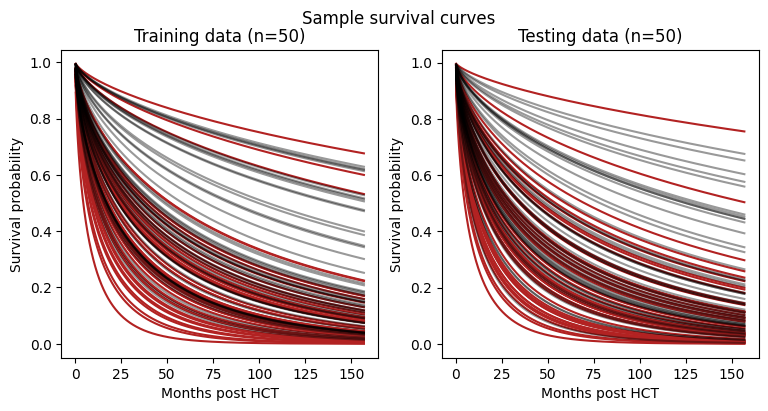

In [11]:
n_curves=50

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Sample survival curves')

efs_positive_ids=training_significant_features_df[training_significant_features_df['efs'] == 1].index
efs_negative_ids=training_significant_features_df[training_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=training_survival_functions[efs_negative_ids]
efs_positive_survival_functions=training_survival_functions[efs_positive_ids]

axs[0].set_title(f'Training data (n={n_curves})')

for i in range(n_curves):
    axs[0].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[0].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[0].set_xlabel('Months post HCT')
axs[0].set_ylabel('Survival probability')

efs_positive_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 1].index
efs_negative_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=testing_survival_functions[efs_negative_ids]
efs_positive_survival_functions=testing_survival_functions[efs_positive_ids]

axs[1].set_title(f'Testing data (n={n_curves})')

for i in range(n_curves):
    axs[1].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[1].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[1].set_xlabel('Months post HCT')
axs[1].set_ylabel('Survival probability')

plt.show()

### 3.2. Survival probability at study end

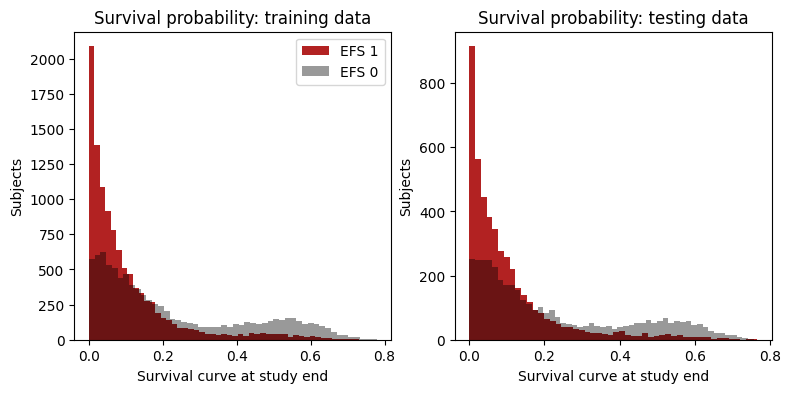

In [12]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Survival probability: training data')
axs[0].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Survival curve at study end')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Survival probability: testing data')
axs[1].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Survival curve at study end')
axs[1].set_ylabel('Subjects')

plt.show()

### 3.3. Expectation value

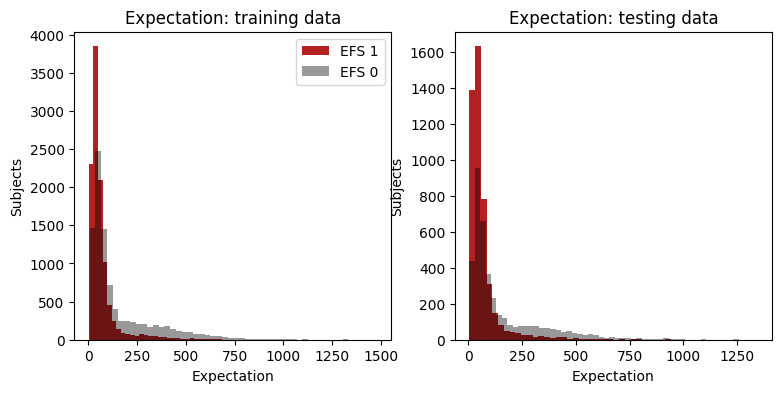

In [13]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Expectation: training data')
axs[0].hist(efs_positive_df['Expectation'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Expectation'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Expectation')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Expectation: testing data')
axs[1].hist(efs_positive_df['Expectation'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Expectation'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Expectation')
axs[1].set_ylabel('Subjects')

plt.show()

### 3.4. C-index scoring

In [14]:
scoring_results=helper_funcs.score_predictions(
    'WeibullAFT survival',
    testing_survival_df['Survival'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    data_dict['Testing race group'],
    data_dict['Testing IDs']
)

scoring_results=helper_funcs.score_predictions(
    'WeibullAFT',
    testing_survival_df['Expectation'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    data_dict['Testing race group'],
    data_dict['Testing IDs'],
    results=scoring_results
)

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,WeibullAFT survival,33.533390,0.636878,0.623571
1,WeibullAFT,165.924573,0.636878,0.623571


## 4. Save survival features

In [15]:
waft_features={
    'Training survival': list(training_survival_df['Survival'].values),
    'Training expectation': list(training_survival_df['Expectation'].values),
    'Testing survival': list(testing_survival_df['Survival'].values),
    'Testing expectation': list(testing_survival_df['Survival'].values)
}

with open(survival_file, 'wb') as output_file:
    pickle.dump(waft_features, output_file)

## 5. Save model

In [16]:
with open(waft_model_file, 'wb') as output_file:
    pickle.dump(waft_model, output_file)